# E-MOSAIC

引用自[E. R. Q. Fernandes, A. C. P. L. F. de Carvalho and X. Yao, "Ensemble of Classifiers Based on Multiobjective Genetic Sampling for Imbalanced Data," in IEEE Transactions on Knowledge and Data Engineering, vol. 32, no. 6, pp. 1104-1115, 1 June 2020, doi: 10.1109/TKDE.2019.2898861.]


## 数据集的预处理 

In [2]:
import numpy as np

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from utils.dataset_utils import get_classes_indexes_counts
import scipy.io as sio  # 从.mat文件中读取数据集
from ucimlrepo import fetch_ucirepo

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

print("#########################加载数据集#########################")
'''
id = :
12 balance_scale  
76 nursery 8、4、12958(4266: 4320: 328: 4044)
'''
# 数据集
# uci_dataset = fetch_ucirepo(id=76)
mat_data = sio.loadmat('../../data/dataset/Nursery.mat')

# 提取变量
# features = uci_dataset.data.features  # 特征数据
# targets = uci_dataset.data.targets  # 标签lable


dataset_x = mat_data['X']
dataset_y = mat_data['Y'][:, 0]  # mat_data['Y']得到的形状为[n,1]，通过[:,0]，得到形状[n,]

# 显示数据集分布
print("特征数据:", dataset_x.shape)
print("label:", dataset_y.shape)
# 统计每个类别的个数，dataset_y.max()+1是类别的个数
classes, counts = get_classes_indexes_counts(dataset_y)  #np.argmax(y_onehot, axis=1)找最大值的索引，将0-1序列转化为0,1,2,3......的整数标签
print("每种类别的数量：", counts)

#############################################划分数据集##################################
print("#########################划分数据集#########################")

x_train, x_test, y_train, y_test = train_test_split(dataset_x, dataset_y, test_size=0.3, random_state=42)

# Standardize the feature data
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(x_train)
#X_test_scaled = scaler.transform(x_test)

# 显示数据集分布
print("特征数据:", x_train.shape)
print("label:", y_train.shape)

# 统计每个类别的个数 np.argmax(y_train, axis=1) Convert one-hot encoded test labels back to single class labels
classes_train, counts_train = get_classes_indexes_counts(y_train)
print("训练集每种类别的数量：", counts_train)

classes_test, counts_test = get_classes_indexes_counts(y_test)
print("测试集每种类别的数量：", counts_test)

print("#########################平衡数据集#########################")
# 确定每个类别的数量
num_instances = int(counts_train.min() * 0.9)  # 向下取整
print("最小数量:", num_instances)

# 在每个类别中随机的选择该数量的实例的索引
balanced_classes = np.array([])
for indexes in classes_train:
    random_selecte_indices = np.random.choice(indexes, size=num_instances, replace=False)
    balanced_classes = np.hstack((balanced_classes, random_selecte_indices))
balanced_classes = np.sort(balanced_classes).astype(int)

# 得到平衡的数据集
balanced_dataset_x = []
balanced_dataset_y = []
for index in balanced_classes:
    balanced_dataset_x.append(x_train[index])
    balanced_dataset_y.append(y_train[index])
balanced_dataset_x = np.array(balanced_dataset_x)
balanced_dataset_y = np.array(balanced_dataset_y).astype(int)

# 显示数据集分布
print("平衡的数据集的特征数据:", balanced_dataset_x.shape)
print("label:", balanced_dataset_y.shape)

# 统计每个类别的个数
classes_balanced_dataset, counts_balanced_dataset = get_classes_indexes_counts(balanced_dataset_y)
print("平衡的数据集中每种类别的数量：", counts_balanced_dataset)

#########################加载数据集#########################
特征数据: (12958, 8)
label: (12958,)
每种类别的数量： [4320 4266 4044  328]
#########################划分数据集#########################
特征数据: (9070, 8)
label: (9070,)
训练集每种类别的数量： [3041 2976 2821  232]
测试集每种类别的数量： [1279 1290 1223   96]
#########################平衡数据集#########################
最小数量: 208
平衡的数据集的特征数据: (832, 8)
label: (832,)
平衡的数据集中每种类别的数量： [208 208 208 208]


## 评价函数
（G-mean,mAUC两个目标）

In [3]:
from scipy.stats import gmean
from sklearn.metrics import precision_score, roc_auc_score, accuracy_score
from scipy.stats import mode


##########################由个体得到选择的实例子集的索引###########################
def get_indices(individual):
    '''
    :param individual: individual（用实值进行编码）
    :return: 被选择实例的索引
    '''
    individual = np.round(individual)  # 数据范围在0-1之间，转化成int的同时会舍去小数部分，从而将个体映射到0-1编码
    indices = np.where(individual == 1)  # 1代表选择该实例，返回值是tuple，tuple[0]取元组中的第一个元素
    return indices[0]


###########################获取实例子集############################
def get_subset(individual):
    '''
    :param individual: 
    :return: 实例子集
    '''
    indices = get_indices(individual)
    x_sub = balanced_dataset_x[indices, :]
    y_sub = balanced_dataset_y[indices]
    return x_sub, y_sub


##########################适应度函数（PPV和PFC，为主要、次要指标）#################################
def fitness_function(individual):
    # 使用训练数据进行预测
    ind_pred = individual.mlp.predict(x_test)  # 计算accuracy、PPV
    index_pred_proba = individual.mlp.predict_proba(x_test)  # 计算mAUC
    ######################G-mean#########################
    # 计算混淆矩阵
    cm = confusion_matrix(y_test, ind_pred)

    # 计算每类召回率（每类正确预测个数 / 该类总数）
    recall_per_class = cm.diagonal() / cm.sum(axis=1)

    # 计算G-Mean
    geometric_mean = gmean(recall_per_class)
    ######################mAUC#######################
    # 计算 ROC AUC（ovo+macro）
    auc_ovo_macro = roc_auc_score(y_test, index_pred_proba, multi_class="ovo", average="macro")
    return round(geometric_mean, 4), round(auc_ovo_macro, 4)


# 集成分类器的投票
def vote_ensembles(save_ensembles):
    y_pred_labels_ensembles = []
    for ensemble in save_ensembles:
        ind_pred = ensemble.predict(x_test)  # 计算accuracy、PPV
        # Convert one-hot encoded test labels back to single class labels
        y_pred_labels_ensembles.append(ind_pred)
    # 按列投票，取每列中出现次数最多的类别作为最终分类结果
    final_pred_result = mode(y_pred_labels_ensembles, axis=0, keepdims=False).mode.flatten()
    cm = confusion_matrix(y_test, final_pred_result)
    # 计算每类召回率（每类正确预测个数 / 该类总数）
    recall_per_class = cm.diagonal() / cm.sum(axis=1)

    # 计算G-Mean
    geometric_mean = gmean(recall_per_class)
    # 计算准确率
    accuracy = accuracy_score(y_test, final_pred_result)
    print(f'Accuracy: {accuracy:.2f}')

    # 打印分类报告
    # print("Classification Report:")
    # print(classification_report(y_test, final_pred_result))

    # 打印混淆矩阵
    # print("Confusion Matrix:")
    # print(confusion_matrix(y_test, final_pred_result))
    return geometric_mean


from array import array


# 在种群中找到重复的个体
def find_duplicates(pop, similar=0.85):
    """
    找到重复个体的索引。
    :param arrays: 一个包含 array.array 的列表
    :param threshold: 重复的判断阈值
    :return: 重复对的索引列表
    """
    n = len(pop)
    duplicates = []  # 用于记录重复对的索引

    for i in range(n):
        for j in range(i + 1, n):
            # 当前两组数组
            a = pop[i]
            b = pop[j]

            # 计算1的个数
            ones_a = sum(a)
            ones_b = sum(b)

            # 如果其中一个数组全是0，不可能满足条件
            if ones_a == 0 or ones_b == 0:
                continue

            # 计算交集中的1的数量
            common_ones = sum(x & y for x, y in zip(a, b))

            # 判断是否满足重复的定义
            if (common_ones / ones_a > similar) and (common_ones / ones_b > similar):
                duplicates.append((i, j))

    return duplicates


# 根据索引对，去除种群中重复的个体
def remove_duplicates(pop, duplicates):
    """
    移除重复的个体。
    :param arrays: 一个包含 array.array 的列表
    :param duplicates: 重复对的索引列表
    :return: 去重后的列表
    """
    # 找到所有需要移除的索引
    to_remove = set(j for _, j in duplicates)  # 只保留后出现的索引
    # 构造去重后的列表
    return [pop[i] for i in range(len(pop)) if i not in to_remove]

## NDGA-II

In [4]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from instance_selection.nsga_2.genetic_operator import selNSGA2, mutate_binary_inversion, selTournamentDCD
import warnings

warnings.filterwarnings("ignore")  # 忽略警告
from sklearn.neural_network import MLPClassifier

import array
import random
import matplotlib.pyplot as plt
from deap import base
from deap import creator
from deap import tools

# 最大化评价目标
creator.create("FitnessMaxAndMax", base.Fitness, weights=(1.0, 1.0))
'''
fitness:适应度：Gmean和mAUC
pfc：每个分类器的成对故障信用，用于评估分类器集合的多样性
'''
creator.create("Individual", array.array, typecode='i', fitness=creator.FitnessMaxAndMax, pfc=None, mlp=None)
toolbox = base.Toolbox()

NDIM = num_instances

# 二进制编码
toolbox.register("attr_binary", random.randint, 0, 1)  # 0-1编码
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_binary, n=num_instances)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", fitness_function)

# 单点交叉
toolbox.register("mate", tools.cxOnePoint)

# 二进制突变
toolbox.register("mutate", mutate_binary_inversion)

# NSGA-II选择
toolbox.register("select", selNSGA2, x_test=x_test, y_test=y_test)

# 找到种群中重复个体的索引对
toolbox.register("find_duplicates", find_duplicates)

# 去重
toolbox.register("remove_duplicates", remove_duplicates)

# 创建一个MLP模型
init_mlp = MLPClassifier(hidden_layer_sizes=(15,), max_iter=500, random_state=42)


# 绘制Pareto Front曲线
def plot_front(fronts, gen, title):
    """绘制当前代非支配排序的第一等级前沿"""
    fitnesses = [ind.fitness.values for ind in fronts]
    plt.scatter(*zip(*fitnesses), marker='o', label=f"Generation {gen}")
    plt.title(title)
    plt.xlabel("mAUC")
    plt.ylabel("G-mean")
    plt.legend()
    plt.grid()
    plt.show()
    plt.close()

## 种群的迭代

Accuracy: 0.71
下一代种群的规模： 40


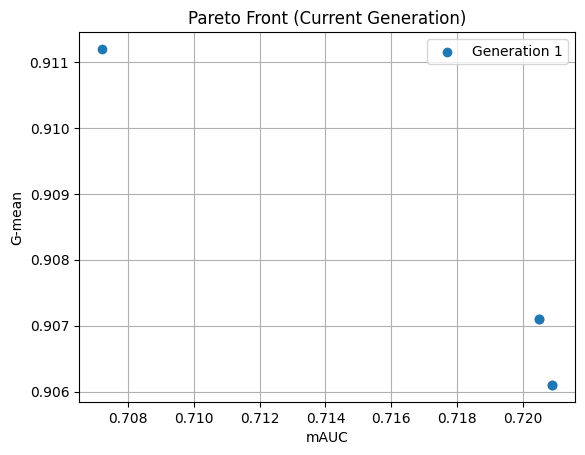

gen	evals	fronts	duplicates	g-mean
1  	40   	5     	34        	      
Accuracy: 0.74
下一代种群的规模： 40


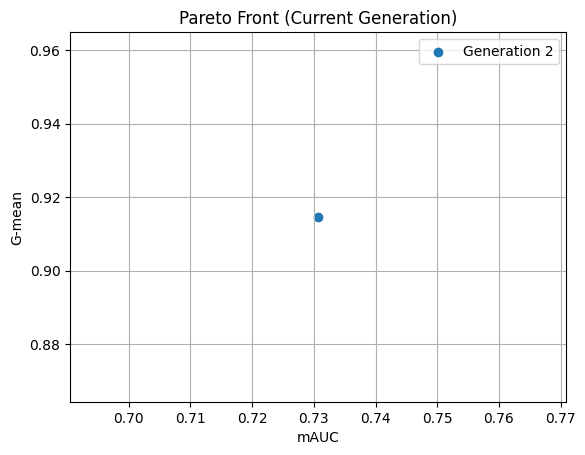

2  	40   	1     	84        	      
Accuracy: 0.75
下一代种群的规模： 40


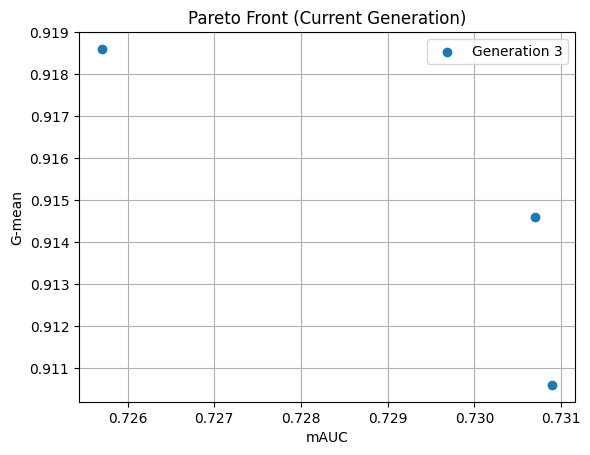

3  	40   	3     	97        	      
Accuracy: 0.74
下一代种群的规模： 40


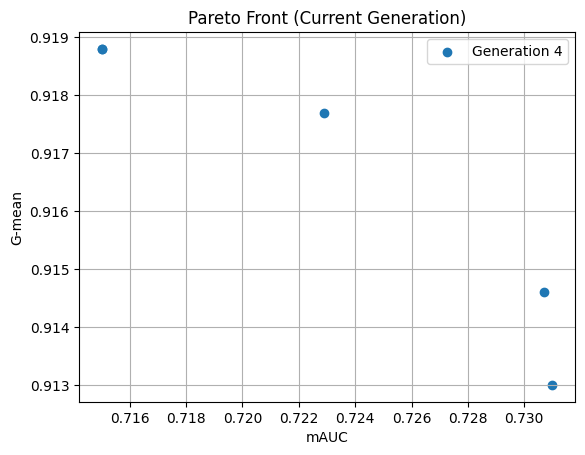

4  	40   	5     	111       	      
Accuracy: 0.74
下一代种群的规模： 40


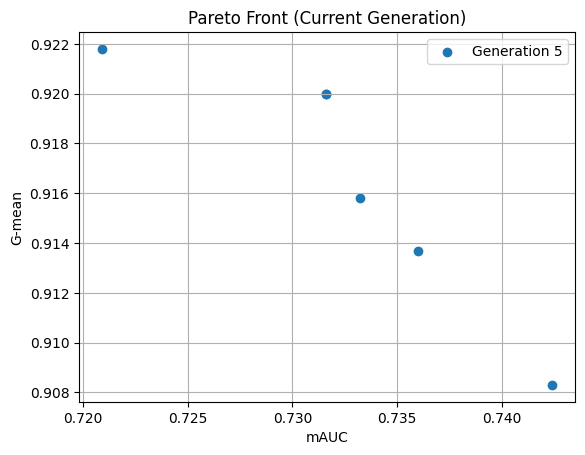

5  	40   	6     	134       	      
Accuracy: 0.75
下一代种群的规模： 40


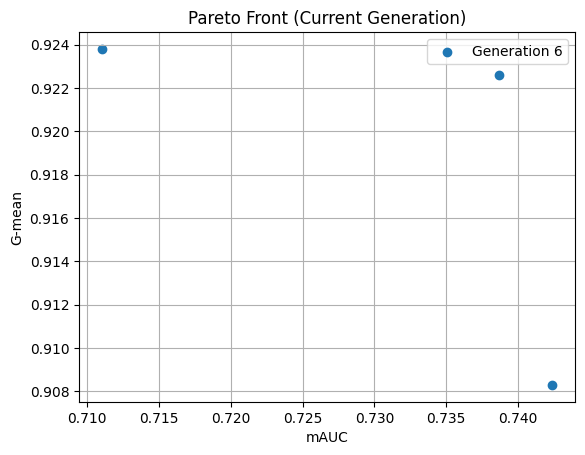

6  	40   	3     	103       	      
Accuracy: 0.76
下一代种群的规模： 40


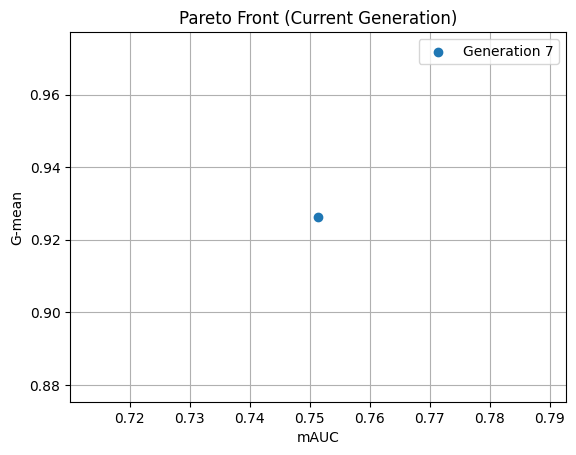

7  	40   	1     	174       	      
Accuracy: 0.76
下一代种群的规模： 40


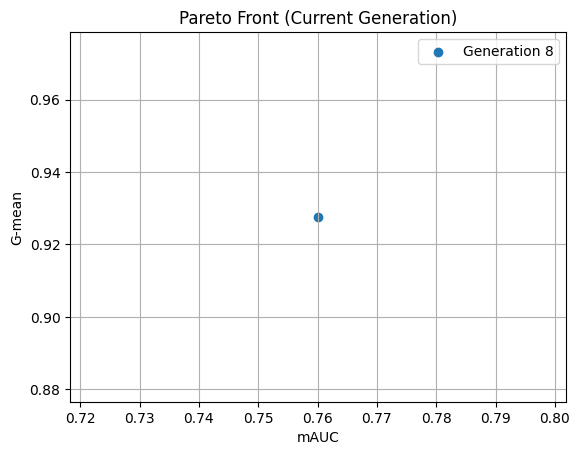

8  	40   	1     	206       	      
Accuracy: 0.76
下一代种群的规模： 40


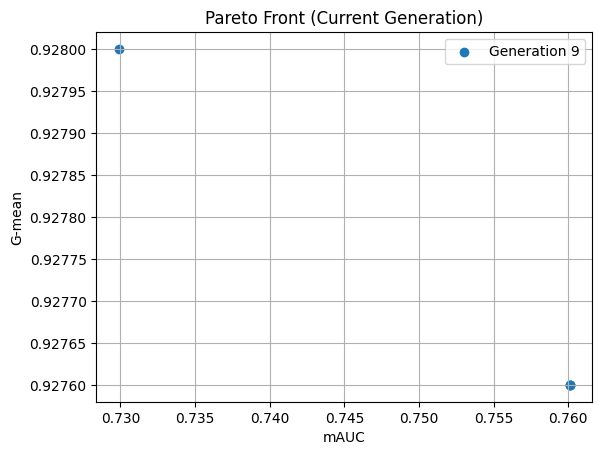

9  	40   	4     	252       	      
Accuracy: 0.76
下一代种群的规模： 40


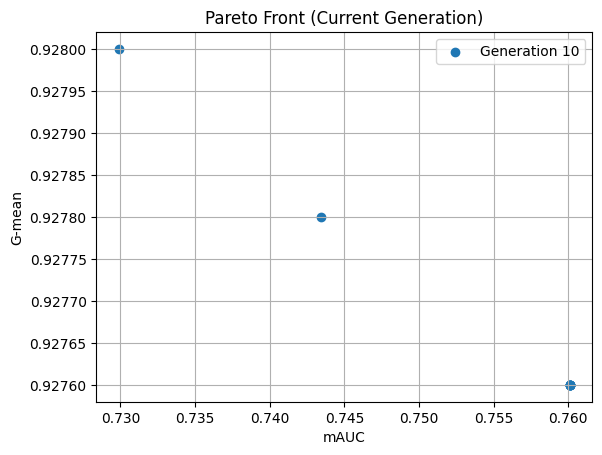

10 	40   	8     	469       	      
Accuracy: 0.76
下一代种群的规模： 40


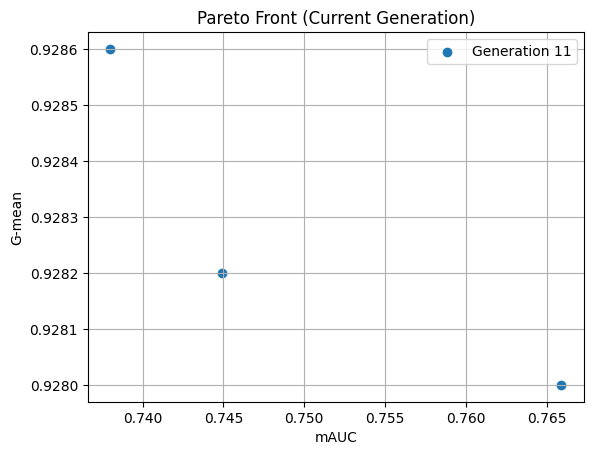

11 	40   	3     	875       	      
Accuracy: 0.76
下一代种群的规模： 40


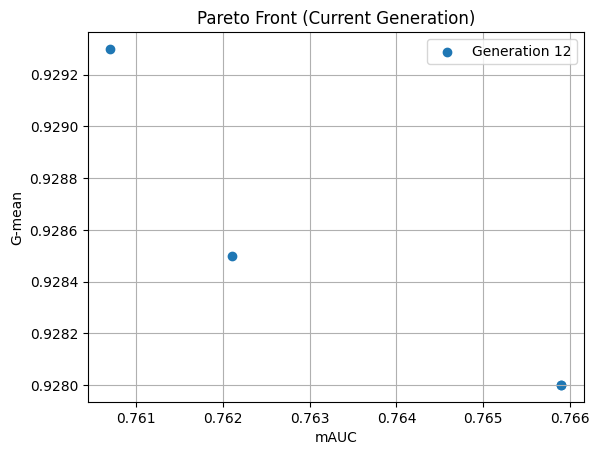

12 	40   	4     	1076      	      
Accuracy: 0.76
下一代种群的规模： 40


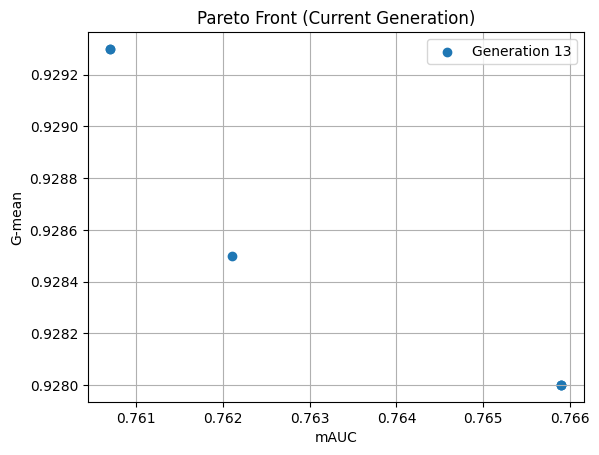

13 	40   	6     	1194      	      
Accuracy: 0.76
下一代种群的规模： 40


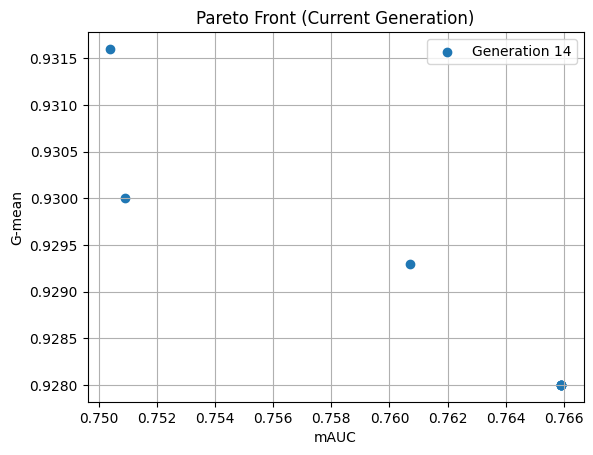

14 	40   	8     	1157      	      
Accuracy: 0.76
下一代种群的规模： 40


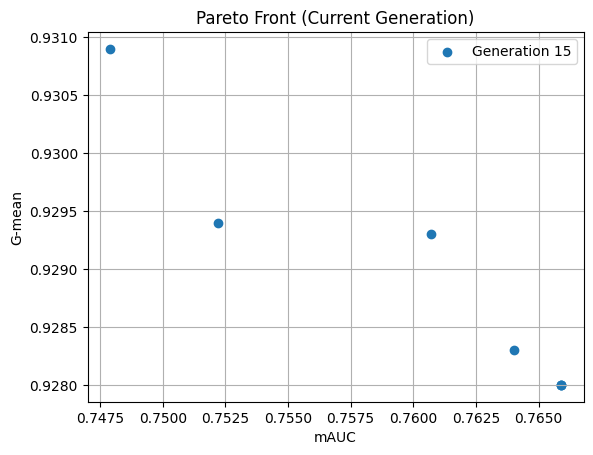

15 	40   	7     	1051      	      
Accuracy: 0.76
下一代种群的规模： 40


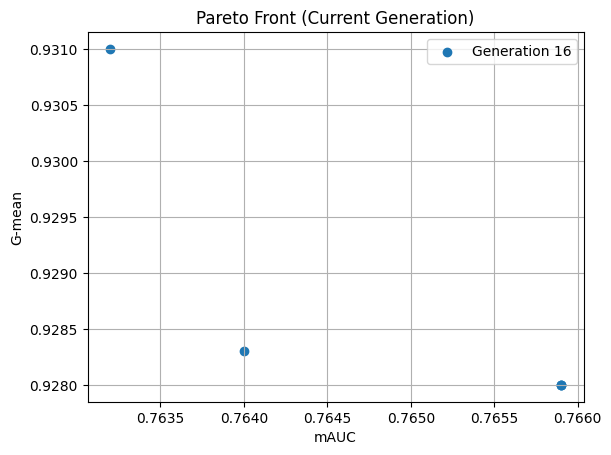

16 	40   	5     	850       	      
Accuracy: 0.76
下一代种群的规模： 40


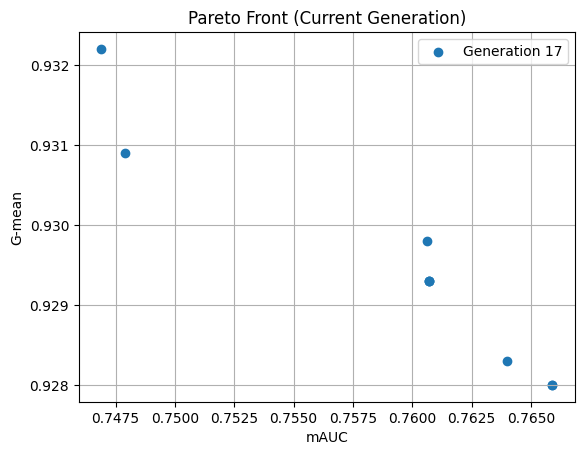

17 	40   	9     	735       	      
Accuracy: 0.76
下一代种群的规模： 40


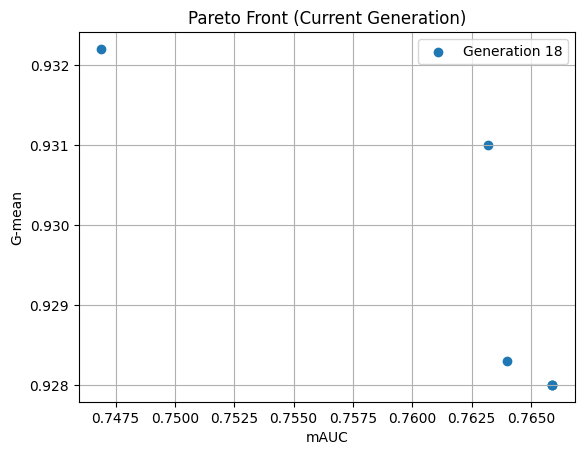

18 	40   	6     	760       	      
Accuracy: 0.76
下一代种群的规模： 40


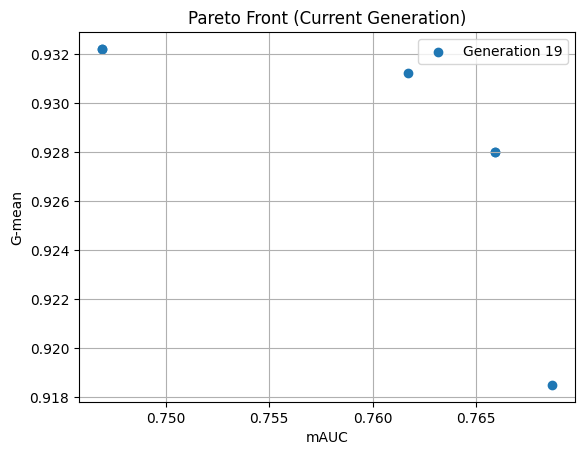

19 	40   	6     	689       	      
Accuracy: 0.76
下一代种群的规模： 40


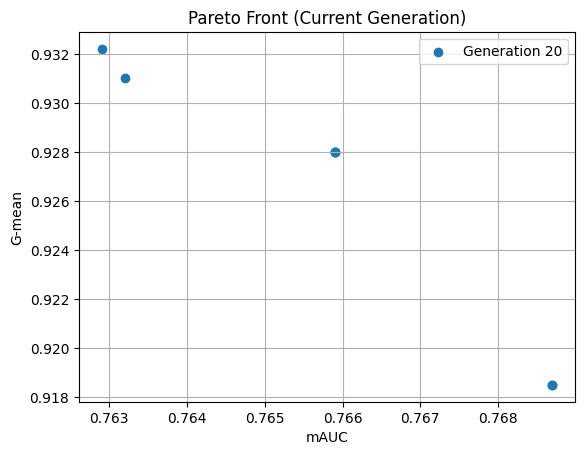

20 	40   	7     	622       	      
Accuracy: 0.76
下一代种群的规模： 40


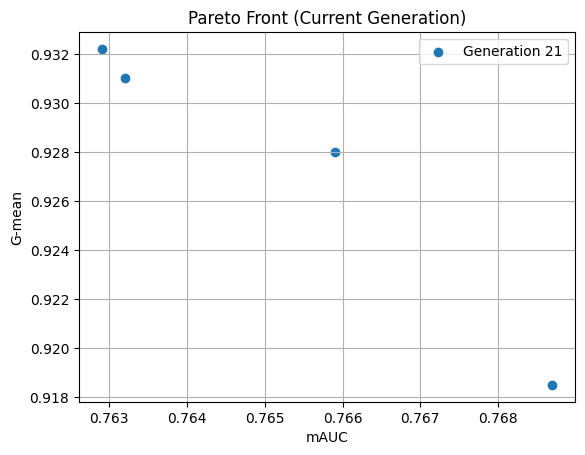

21 	40   	4     	729       	      
Accuracy: 0.77
下一代种群的规模： 40


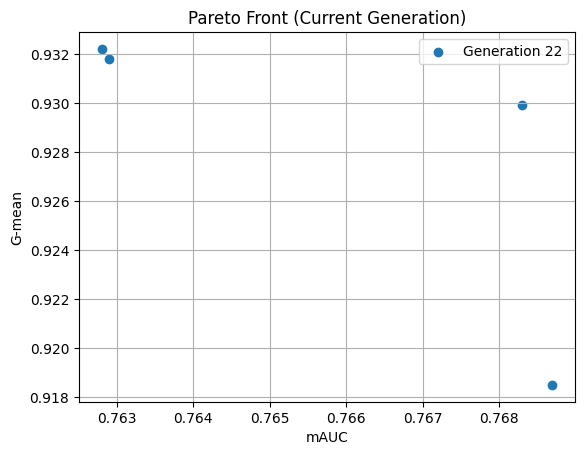

22 	40   	4     	760       	      
Accuracy: 0.77
下一代种群的规模： 40


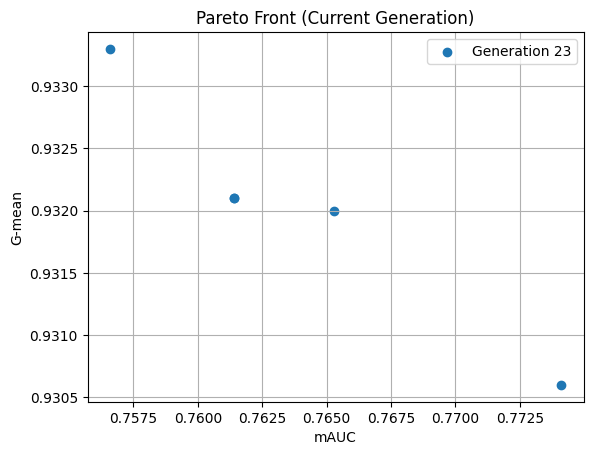

23 	40   	5     	792       	      
Accuracy: 0.77
下一代种群的规模： 40


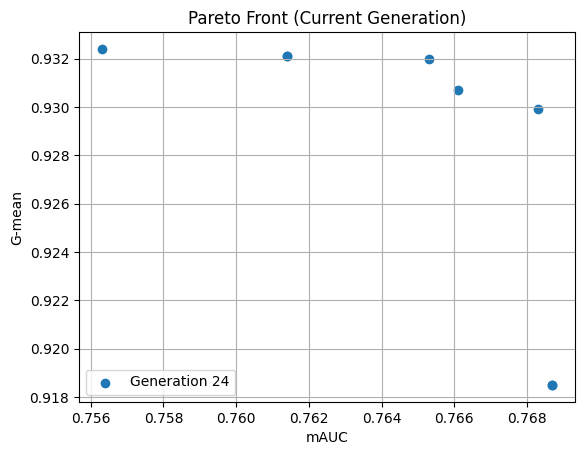

24 	40   	8     	910       	      
Accuracy: 0.77
下一代种群的规模： 40


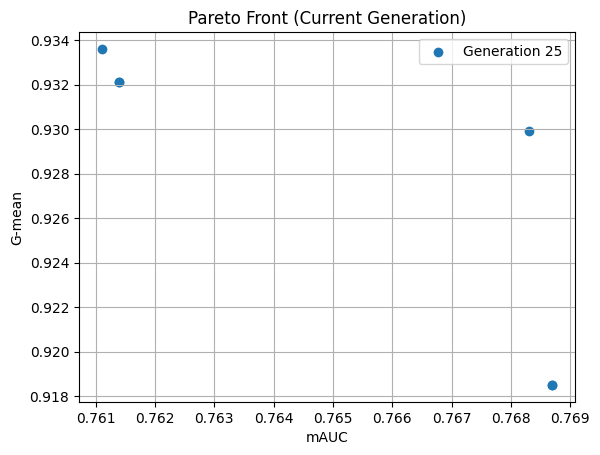

25 	40   	6     	869       	      
Accuracy: 0.78
下一代种群的规模： 40


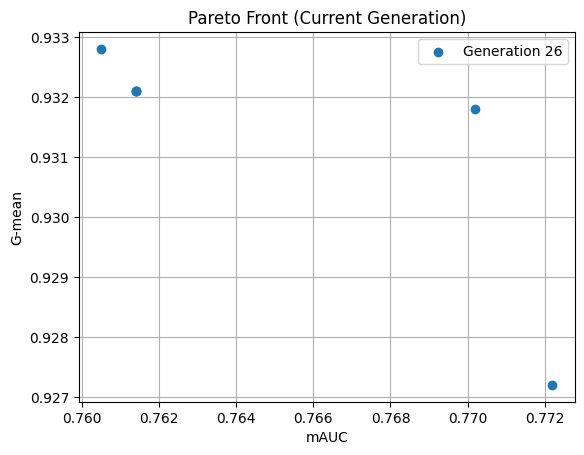

26 	40   	6     	714       	      
Accuracy: 0.77
下一代种群的规模： 40


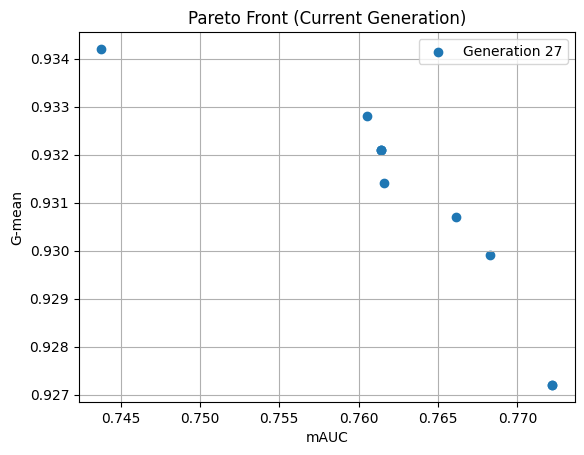

27 	40   	10    	743       	      
Accuracy: 0.77
下一代种群的规模： 40


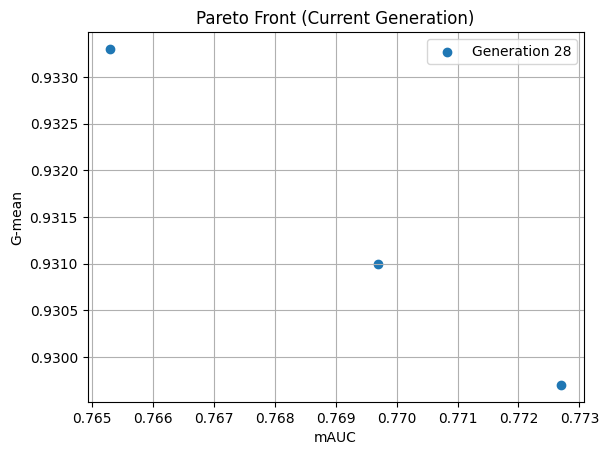

28 	40   	3     	774       	      
Accuracy: 0.77
下一代种群的规模： 40


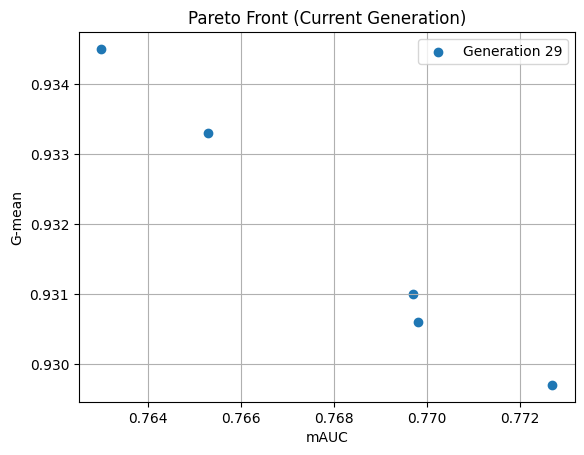

29 	40   	5     	925       	      
Accuracy: 0.77
下一代种群的规模： 40


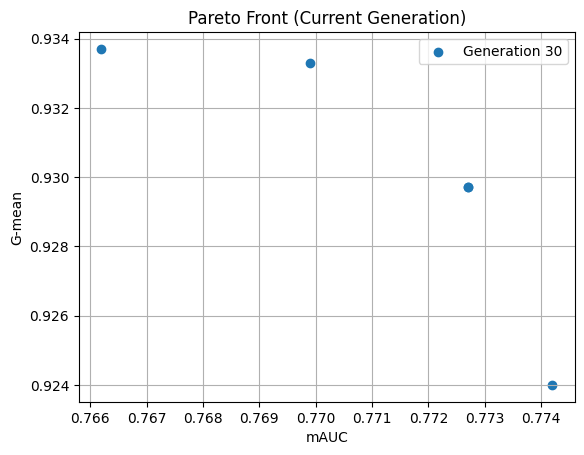

30 	40   	5     	1064      	      
Accuracy: 0.77
##############################集成分类器的预测结果：################################
Accuracy: 0.77


In [6]:
def main(seed=None):
    random.seed(seed)

    NGEN = 30  # 迭代次数
    POPSIZE = 40  # 种群数量
    CXPB = 1.0  # 交叉因子/交叉率
    MR = 0.2  # 突变因子/突变率
    SIMILAR = 0.85

    ####################################迭代过程的记录#############################
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    logbook = tools.Logbook()
    logbook.header = "gen", "evals", "fronts", "duplicates", "g-mean"
    ####################################种群的初始化###########################
    pop = toolbox.population(n=POPSIZE)
    ####################################计算初始种群的适应度###########################
    stop_sign = 0
    ensembles = []  # 当前每个个体对应的mlp模型
    save_ensembles = []  # 保存最好的集成模型
    current_ensembles = []  # 存储当前种群对应的集成模型
    g_means_record = [0]
    #pop_x_sub = []  # 当前每个个体的实例选择的特征数据
    #pop_y_sub = []  # 当前每个个体对应的实例选择的lable
    duplicates = []
    # 对于每个个体都训练得到一个mlp模型
    for i in range(len(pop)):
        mlp = MLPClassifier(hidden_layer_sizes=(15,), max_iter=500, random_state=42)
        x_sub, y_sub = get_subset(pop[i])
        mlp.fit(x_sub, y_sub)
        ensembles.append(mlp)
        #pop_x_sub.append(x_sub)
        #pop_y_sub.append(y_sub)
        pop[i].mlp = mlp

    # 由mlp模型得到个体的适应度
    for i in range(len(pop)):
        pop[i].fitness.values = toolbox.evaluate(pop[i])

    #################################计算PFC并进行非支配排序#########################################
    # 计算PFC并进行非支配排序 PFC代替拥挤距离
    pop, pareto_fronts = toolbox.select(pop, len(pop))
    # 保存第一个pareto_front中的模型，进行集成
    for ind in pareto_fronts[0]:
        save_ensembles.append(ind.mlp)
    g_mean = vote_ensembles(save_ensembles)
    g_means_record.append(g_mean)

    # record = stats.compile(pop)
    # logbook.record(gen=0, evals=len(pop), **record)
    # print(logbook.stream)
    ####################################种群的迭代#################################################
    for gen in range(1, NGEN + 1):
        # 清空当前的集成分类器
        current_ensembles.clear()
        # 选择
        offspring = selTournamentDCD(pop, POPSIZE)
        offspring = [toolbox.clone(ind) for ind in offspring]
        # 交叉
        for i in range(0, len(offspring) - 1, 2):
            if random.random() <= CXPB:
                offspring[i], offspring[i + 1] = toolbox.mate(offspring[i], offspring[i + 1])
            # 突变
            offspring[i] = toolbox.mutate(offspring[i], MR)[0]
            offspring[i + 1] = toolbox.mutate(offspring[i + 1], MR)[0]
            del offspring[i].fitness.values, offspring[i + 1].fitness.values

        # 计算新的种群适应度 
        ensembles.clear()
        #pop_x_sub.clear()
        #pop_y_sub.clear()
        for i in range(len(offspring)):
            mlp = MLPClassifier(hidden_layer_sizes=(15,), max_iter=500, random_state=42)
            x_sub, y_sub = get_subset(offspring[i])
            mlp.fit(x_sub, y_sub)
            ensembles.append(mlp)
            #pop_x_sub.append(x_sub)
            #pop_y_sub.append(y_sub)
            offspring[i].mlp = mlp
        for i in range(len(offspring)):
            offspring[i].fitness.values = toolbox.evaluate(offspring[i])

        # 种群的合并
        new_pop = pop + offspring

        # 找到重复个体的索引对
        duplicates = toolbox.find_duplicates(new_pop, SIMILAR)
        # 去除对应重复的个体
        new_pop = toolbox.remove_duplicates(new_pop, duplicates)
        ###########################################再次进行突变################################################
        for ind in range(len(offspring)):
            # 突变
            offspring[i] = toolbox.mutate(offspring[i], MR)[0]
            del offspring[i].fitness.values
        # 计算新的种群适应度 
        ensembles.clear()
        #pop_x_sub.clear()
        #pop_y_sub.clear()
        for i in range(len(offspring)):
            mlp = MLPClassifier(hidden_layer_sizes=(15,), max_iter=500, random_state=42)
            x_sub, y_sub = get_subset(offspring[i])
            mlp.fit(x_sub, y_sub)
            ensembles.append(mlp)
            #pop_x_sub.append(x_sub)
            #pop_y_sub.append(y_sub)
            offspring[i].mlp = mlp
        for i in range(len(offspring)):
            offspring[i].fitness.values = toolbox.evaluate(offspring[i])

        # 种群的合并
        pop = new_pop + offspring
        ###############################################得到pareto_fronts############################################
        pop, pareto_fronts = toolbox.select(pop, POPSIZE)
        print("下一代种群的规模：",len(pop))
        plot_front(pareto_fronts[0], gen, title="Pareto Front (Current Generation)")
        record = stats.compile(pop)
        logbook.record(gen=gen, evals=len(pop), fronts=len(pareto_fronts[0]), duplicates=len(duplicates), g_mean=g_means_record[-1] ,**record)
        print(logbook.stream)
        # 保存第一个等级里的mlp模型进行集成
        for ind in pareto_fronts[0]:
            current_ensembles.append(ind.mlp)
        g_mean = vote_ensembles(current_ensembles)
        if g_mean > g_means_record[-1]:  # 当前的gmean与列表最后一个gmean做对比
            save_ensembles = current_ensembles
            g_means_record.append(g_mean)
            stop_sign = 0
        else:
            stop_sign += 1
        if stop_sign == 10:
            break
    return pop, logbook, save_ensembles


if __name__ == "__main__":
    pop, stats, ensembles = main()

    print("##############################集成分类器的预测结果：################################")
    vote_ensembles(ensembles)